In [34]:
# General
import pandas as pd
import numpy as np
import datetime
import os
import glob
import sqlite3
from math import ceil

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

#pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

#feature selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE,f_classif
from sklearn.linear_model import LogisticRegression

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import set_link_color_palette

import warnings
warnings.filterwarnings('ignore')

# Importing data

In [35]:
df = pd.read_csv('../data/MACIMIDE_Global_Expatriate_Dual_Citizenship_Dataset_V5.00.csv')

try:
    wdi = pd.read_csv('../data/WDIData.csv',usecols = range(65))
except:
    #saves the WDIData table without extracting the zip file
    with zipfile.ZipFile('../data/WDI_csv.zip') as myzip:
        wdi = pd.read_csv(myzip.open('WDIData.csv'),usecols = range(65))
        country = pd.read_csv(myzip.open('WDICountry.csv'))
        ind = pd.read_csv(myzip.open('WDISeries.csv'))

# Cleaning data

1. Keeping only the countries in WDI data
2. Keep years from 2000 to 2020

In [36]:
# 1. Keep only countries
cname = wdi.drop_duplicates(subset='Country Name')['Country Name']
wdi = wdi.loc[~wdi['Country Name'].isin(cname[:49])]

# 2. Keep only years we want
df = df.query('Year >= 2000 & Year <2020')
wdi = pd.concat([wdi.iloc[:,:4],wdi.iloc[:,44:-1]],axis=1)

# Changing world Region and selecting some countries

In [37]:
country_old = df.loc[df.world_region.isna()]['country'].unique()
df = df.loc[~df['country'].isin(country_old)]
def world_region(x):
    if x == 1:
        return 'Africa'
    elif x == 2:
        return 'Asia'
    elif x == 3:
        return 'Europe'
    elif x== 6:
        return 'Oceania'
    else:
        return 'America'    
    
df['world_region'] = df['world_region'].apply(lambda x:world_region(x) )
df = df.query('Year >= 2000 & Year <2020')


In [38]:
America = ["United States of America",'Canada','Mexico','Brazil', 'Colombia','Chile','Argentina']
Europe = ['Italy', 'Germany', 'Denmark', 'Poland', 'United Kingdom (of Great Britain and Northern Ireland)','France','Netherlands']
Extreme_Orient = ['China',  'Thailand', 'Australia', 'India',  'Azerbaijan','Japan']
Africa = ['South Africa', 'Djibouti', 'Morocco', 'Nigeria', 'Botswana']
Countries = [c for i in (America,Europe,Africa,Extreme_Orient) for c in i]

df_country = df.copy()
df_country = df.loc[df['country'].isin((Countries))]
len(df_country['country'].unique())

25

In [39]:
wdi.head()

,Country Name,Country Code,Indicator Name,Indicator Code,2000,2001,2002,2003,2004,2005,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
70707,Afghanistan,AFG,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,8.8,9.51,10.39,11.46,12.43,13.490000,...,20.6800,22.330000,24.080000,26.170000,27.990000,30.100000,32.44000,NaN,NaN,NaN
70708,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,22.295269,...,42.7000,43.222019,69.100000,68.982941,89.500000,71.500000,97.70000,97.700000,98.715622,97.70000
70709,Afghanistan,AFG,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,7.109005,...,30.2188,29.572881,60.849157,61.315788,86.500512,64.573354,97.09936,97.091973,98.309603,96.90219
70710,Afghanistan,AFG,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,74.000000,...,82.8000,86.567779,95.000000,92.773354,98.700000,92.500000,99.50000,99.500000,99.902145,100.00000
70711,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.005013,NaN,NaN,9.961000,NaN,NaN,14.893312,NaN,NaN


# Missing Values Treatment

First we are going to filter indicators with more than 20% of the data as nan values along countries and years. Inputation in thoses cases would change too much the analysis

In [40]:
Indicator_names = np.mean(1 -wdi.groupby('Indicator Name').count().iloc[:,3:-1]/217,axis =1)
Indicator_little_nan = pd.DataFrame(Indicator_names[Indicator_names<.06].sort_values(),columns=['% of nan'])
Indicator_little_nan

,% of nan
Indicator Name,
Adjusted savings: mineral depletion (current US$),0.000000
"Population, total",0.001698
Population growth (annual %),0.001698
Land area (sq. km),0.002911
Population density (people per sq. km of land area),0.002911
Surface area (sq. km),0.005578
Urban population (% of total population),0.010914
Urban population growth (annual %),0.010914
Rural population,0.010914


In [41]:
# select indicators with less nan values
filtered_wdi = wdi.loc[wdi['Indicator Name'].isin(Indicator_little_nan.index)]

In [42]:
s = filtered_wdi.groupby(['Country Code','Indicator Name']).count().sum(axis = 1) / 22
pd.DataFrame(s,columns=["%nan"]).reset_index().groupby('Indicator Name').mean().sort_values("%nan")

,%nan
Indicator Name,
Arable land (hectares per person),0.909091
Arable land (hectares),0.909091
Arable land (% of land area),0.909091
Agricultural land (% of land area),0.919355
Agricultural land (sq. km),0.919355
Renewable energy consumption (% of total final energy consumption),0.938626
Capture fisheries production (metric tons),0.939045
Total fisheries production (metric tons),0.939045
Fixed telephone subscriptions (per 100 people),0.943653


Now, for the X indicator left we should try to inputate the missing values by some of the below methods:
- KNNImputer
- mode (by Population density and GDP per capta)
- mean (by Population density and GDP per capta)

the *'by Population density and GDP per capta'* suppose to find the best mode and mean along countries, otherwise inputation would be too bias. Both indicatiors have few nan values and take in consideration important factors in selecting similar countries.

In [43]:
np.sqrt(len(Indicator_little_nan))

6.708203932499369

In [44]:
# knn imputer
imputer = KNNImputer(n_neighbors=10)
filtered_wdi.iloc[:,4:] = imputer.fit_transform(filtered_wdi.iloc[:,4:])
filtered_wdi

,Country Name,Country Code,Indicator Name,Indicator Code,2000,2001,2002,2003,2004,2005,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
70708,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,2.910849e+01,2.915522e+01,3.189710e+01,3.478334e+01,3.670975e+01,2.229527e+01,...,4.270000e+01,4.322202e+01,6.910000e+01,6.898294e+01,8.950000e+01,7.150000e+01,9.770000e+01,9.770000e+01,9.871562e+01,9.770000e+01
70710,Afghanistan,AFG,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,7.269276e+01,7.361219e+01,7.664915e+01,7.711550e+01,7.859403e+01,7.400000e+01,...,8.280000e+01,8.656778e+01,9.500000e+01,9.277335e+01,9.870000e+01,9.250000e+01,9.950000e+01,9.950000e+01,9.990215e+01,1.000000e+02
70738,Afghanistan,AFG,Adjusted savings: carbon dioxide damage (curre...,NY.ADJ.DCO2.CD,1.436535e+07,1.586448e+07,2.157660e+07,2.547320e+07,2.020204e+07,3.084251e+07,...,2.416302e+08,3.647899e+08,3.340286e+08,2.924376e+08,2.849291e+08,3.141359e+08,3.114902e+08,3.473530e+08,3.839152e+08,4.336361e+08
70744,Afghanistan,AFG,Adjusted savings: energy depletion (current US$),NY.ADJ.DNGY.CD,1.797047e+06,1.078196e+06,9.725494e+05,9.475434e+05,1.235225e+06,1.469289e+06,...,1.044313e+07,2.649364e+07,3.447720e+07,1.494763e+07,1.410024e+07,9.737235e+06,1.293113e+07,2.153331e+07,2.826238e+07,2.074859e+07
70747,Afghanistan,AFG,Adjusted savings: mineral depletion (current US$),NY.ADJ.DMIN.CD,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,3.654550e+05,4.721533e+05,3.051536e+05,3.888372e+05,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383679,Zimbabwe,ZWE,Surface area (sq. km),AG.SRF.TOTL.K2,3.907600e+05,3.907600e+05,3.907600e+05,3.907600e+05,3.907600e+05,3.907600e+05,...,3.907600e+05,3.907600e+05,3.907600e+05,3.907600e+05,3.907600e+05,3.907600e+05,3.907600e+05,3.907600e+05,3.907600e+05,3.981013e+05
383741,Zimbabwe,ZWE,Total fisheries production (metric tons),ER.FSH.PROD.MT,9.716300e+04,9.074200e+04,9.369500e+04,8.695700e+04,7.369000e+04,8.229600e+04,...,9.497700e+04,1.101170e+05,1.091610e+05,1.389890e+05,1.554850e+05,1.409990e+05,1.392870e+05,1.110100e+05,1.258820e+05,1.305048e+05
383808,Zimbabwe,ZWE,Urban population,SP.URB.TOTL,4.010951e+06,4.074399e+06,4.134392e+06,4.131349e+06,4.122108e+06,4.119361e+06,...,4.215138e+06,4.257061e+06,4.306228e+06,4.359432e+06,4.416224e+06,4.473872e+06,4.531238e+06,4.589452e+06,4.650597e+06,4.717307e+06
383809,Zimbabwe,ZWE,Urban population (% of total population),SP.URB.TOTL.IN.ZS,3.375800e+01,3.417000e+01,3.458500e+01,3.447900e+01,3.429400e+01,3.411000e+01,...,3.319600e+01,3.301500e+01,3.283400e+01,3.265400e+01,3.250400e+01,3.238500e+01,3.229600e+01,3.223700e+01,3.220900e+01,3.221000e+01


# Pre processing Data


In [45]:
#2019 data
wdi_pivoted = filtered_wdi.pivot(index='Country Code',columns='Indicator Name', values='2019')

dual_city_groups_2019 = df.loc[df.Year==2019].set_index('ISO3')[['Dualcit_grouped']]

wdi_scaled = wdi_pivoted.join(dual_city_groups_2019).dropna(subset=['Dualcit_grouped'])


scaler = MinMaxScaler()

wdi_scaled.iloc[:,:-1] = scaler.fit_transform(wdi_scaled.iloc[:,:-1])

# Selecting Features

### Filter Methods
- Kendalls correlation
- Anova correlation

### Wrapper methods
- RFE

### Assamble Methods
- random forest split

In [46]:
cor_kendall = wdi_scaled.corr(method ='kendall')
cor_kendall[['Dualcit_grouped']].sort_values('Dualcit_grouped',ascending=False)

,Dualcit_grouped
Dualcit_grouped,1.000000
"Access to electricity, urban (% of urban population)",0.105596
Agricultural land (% of land area),0.100209
Access to electricity (% of population),0.083226
Urban population (% of total population),0.063845
Fixed telephone subscriptions (per 100 people),0.054857
"Primary education, duration (years)",0.041614
People using at least basic sanitation services (% of population),0.037554
"Birth rate, crude (per 1,000 people)",0.031138
Lower secondary school starting age (years),0.024094


In [33]:
def kmeans_Hierarchical(considered_df,threshold=0.3):
    kmeans = KMeans(n_clusters=30, random_state=0).fit(considered_df)
    considered_df['Cluster'] = pd.Series(kmeans.labels_,index=wdi_scaled.index)
    kmeans_clusters = considered_df.groupby("Cluster").mean()
    considered_df.drop('Cluster',axis=1,inplace=True)
    
    # Hierarchical clustering assessment using scipy
    Z = linkage(kmeans_clusters, method='ward')
    sns.set()
    fig = plt.figure(figsize=(15,7))

    # Dendrogram
    set_link_color_palette(list(sns.color_palette().as_hex()))
    dendrogram(Z, color_threshold = threshold*max(Z[:,2]), orientation='top', no_labels=True, above_threshold_color='k')

    plt.hlines(threshold*max(Z[:,2]), 0, 1000, colors="r", linestyles="dashed")
    plt.title('Hierarchical Clustering - Ward\'s Dendrogram', fontsize=23)
    plt.xlabel('SOM Units', fontsize=13)
    plt.ylabel('Euclidean Distance', fontsize=13)
    plt.show()

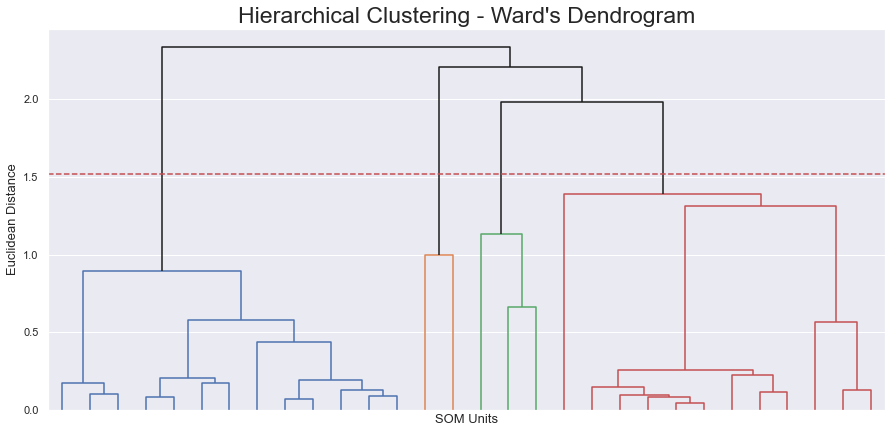

In [113]:
#Select variables
indicators =   ['Access to electricity, urban (% of urban population)',
                'Agricultural land (% of land area)',
                'Access to electricity (% of population)',
                'GDP (current US$)',
                'Land area (sq. km)',
                'Population, total',
                #'Adjusted savings: energy depletion (current US$)',
                'Renewable energy consumption (% of total final energy consumption)']

select_data = wdi_scaled[indicators]

kmeans_Hierarchical(select_data,0.65)

According to the dendogram, the number of cluster is 5. We are going to do a Kmeans with this K

In [111]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(select_data)
select_data['Cluster'] = pd.Series(kmeans.labels_,index=select_data.index)
cluster2019 = pd.concat([select_data,wdi_scaled[['Dualcit_grouped']]],axis=1)

cluster2019.head()

,"Access to electricity, urban (% of urban population)",Agricultural land (% of land area),Access to electricity (% of population),GDP (current US$),Land area (sq. km),"Population, total",Renewable energy consumption (% of total final energy consumption),Cluster,Dualcit_grouped
Country Code,,,,,,,,,
AFG,1.193129e-11,7.896164e-12,0.975343,0.000898,0.039865,0.027210,2.103702e-12,1,2.0
AGO,8.136675e-12,6.252822e-12,0.417560,0.004170,0.076126,0.022762,6.361394e-12,0,2.0
ALB,1.193129e-11,5.818182e-12,1.000000,0.000711,0.001673,0.002034,5.122311e-12,1,2.0
AND,1.193129e-11,5.289095e-12,1.000000,0.000145,0.000029,0.000047,2.621146e-12,1,1.0
ARE,1.193129e-11,7.305662e-13,1.000000,0.019647,0.004336,0.006983,1.457367e-14,1,1.0


Distribution of dualcit

In [65]:
cluster2019.Dualcit_grouped.value_counts()

2.0    126
1.0     49
3.0     18
Name: Dualcit_grouped, dtype: int64

DataFrame with the duacit separedted by column. This is goint to make easier 

In [99]:
cluster2019 = pd.concat([cluster2019,pd.get_dummies(cluster2019.Dualcit_grouped)],axis=1)
cluster2019.drop('Dualcit_grouped',inplace=True,axis=1)
cluster2019

,"Access to electricity, urban (% of urban population)",Agricultural land (% of land area),Access to electricity (% of population),GDP (current US$),Land area (sq. km),"Population, total",Renewable energy consumption (% of total final energy consumption),Cluster,1.0,2.0,3.0
Country Code,,,,,,,,,,,
AFG,1.193129e-11,7.896164e-12,0.975343,0.000898,0.039865,0.027210,2.103702e-12,1,0,1,0
AGO,8.136675e-12,6.252822e-12,0.417560,0.004170,0.076126,0.022762,6.361394e-12,0,0,1,0
ALB,1.193129e-11,5.818182e-12,1.000000,0.000711,0.001673,0.002034,5.122311e-12,1,0,1,0
AND,1.193129e-11,5.289095e-12,1.000000,0.000145,0.000029,0.000047,2.621146e-12,1,1,0,0
ARE,1.193129e-11,7.305662e-13,1.000000,0.019647,0.004336,0.006983,1.457367e-14,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
WSM,1.193129e-11,3.320826e-12,0.991424,0.000038,0.000173,0.000133,4.873849e-12,1,0,1,0
YEM,1.099000e-11,5.990392e-12,0.707885,0.001688,0.032239,0.020856,4.659463e-13,1,0,0,1
ZAF,1.026419e-11,1.090694e-11,0.839193,0.016394,0.074073,0.041888,1.384395e-12,1,1,0,0


In [100]:
cluster2019_agg_ind = cluster2019[indicators+['Cluster']].groupby("Cluster").mean()
cluster2019_agg_duacit = cluster2019[[1.0,2.0,3.0,'Cluster']].groupby("Cluster").sum()
pd.concat([cluster2019_agg_ind,cluster2019_agg_duacit],axis=1)

,"Access to electricity, urban (% of urban population)",Agricultural land (% of land area),Access to electricity (% of population),GDP (current US$),Land area (sq. km),"Population, total",Renewable energy consumption (% of total final energy consumption),1.0,2.0,3.0
Cluster,,,,,,,,,,
0,8.236134e-12,5.993575e-12,0.400928,0.008709,0.032745,0.017048,8.870336e-12,20,24,3
1,1.398601e-02,6.993007e-03,0.977972,0.015139,0.035317,0.017091,1.398603e-02,27,101,15
2,1.193129e-11,7.278735e-12,0.992193,0.600059,0.438531,0.737502,2.393164e-12,2,1,0


In [140]:
#Kprototype
from kmodes.kprototypes import KPrototypes
pd.set_option('display.float_format', lambda x: '%.2f' % x)

selected_clusters = pd.concat([select_data,wdi_scaled[['Dualcit_grouped']]],axis=1)
Kpro_cluster = KPrototypes(n_jobs = -1,n_clusters=3, init='Huang', random_state=42)
kpro_labels = Kpro_cluster.fit_predict(selected_clusters, categorical=[7])

#wdi_scaled.iloc[:,:-1] = scaler.inverse_transform(wdi_scaled.iloc[:,:-1])
selected_clusters = pd.concat([wdi_scaled[indicators],pd.get_dummies(selected_clusters.Dualcit_grouped)],axis=1)
selected_clusters['clusters'] = kpro_labels

selected_clusters.groupby('clusters').mean()

,"Access to electricity, urban (% of urban population)",Agricultural land (% of land area),Access to electricity (% of population),GDP (current US$),Land area (sq. km),"Population, total",Renewable energy consumption (% of total final energy consumption),1.0,2.0,3.0
clusters,,,,,,,,,,
0,69.13,49.28,37.35,30272428499.40,556770.90,25009397.04,70.76,0.28,0.64,0.08
1,95.80,177585107845.46,89.16,1034819217112.10,668034.37,102258993.68,177585252816.96,0.95,0.00,0.05
2,125534300447.90,37.34,98.08,433169513029.11,707126.40,21873727.59,62767227058.50,0.00,0.89,0.11


In [145]:
selected_clusters.loc[selected_clusters['Access to electricity, urban (% of urban population)']>100]

filtered_wdi.loc[filtered_wdi['Country Code']=='DMA']

,Country Name,Country Code,Indicator Name,Indicator Code,2000,2001,2002,2003,2004,2005,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
150073,Dominica,DMA,Access to electricity (% of population),EG.ELC.ACCS.ZS,80.97,82.31,87.70,84.97,86.28,87.58,...,94.07,95.40,96.77,98.16,99.57,99.78,99.97,100.00,100.00,100.00
150075,Dominica,DMA,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,461021554277.21,514083579522.40,579957374020.39,647425413497.17,750537847781.12,883295553562.72,...,1891731507733.98,2241675105032.24,2504097141835.29,2950530698211.78,3290246593857.07,3440818923398.61,3796757143002.32,4263869611882.87,4947939535744.71,7280989420323.73
150103,Dominica,DMA,Adjusted savings: carbon dioxide damage (curre...,NY.ADJ.DCO2.CD,1906302.63,2134234.68,2068989.04,2462665.77,3151518.39,3322811.98,...,4920545.05,4589926.60,5124885.40,5450620.33,5923169.08,6119530.49,6453707.13,6265859.20,6713523.14,7246482.22
150109,Dominica,DMA,Adjusted savings: energy depletion (current US$),NY.ADJ.DNGY.CD,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
150112,Dominica,DMA,Adjusted savings: mineral depletion (current US$),NY.ADJ.DMIN.CD,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
150130,Dominica,DMA,Agricultural land (% of land area),AG.LND.AGRI.ZS,28.00,29.33,29.33,29.33,29.33,29.33,...,33.33,33.33,33.33,33.33,33.33,33.33,33.33,33.33,33.33,34.01
150131,Dominica,DMA,Agricultural land (sq. km),AG.LND.AGRI.K2,210.00,220.00,220.00,220.00,220.00,220.00,...,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,249.03
150161,Dominica,DMA,Arable land (% of land area),AG.LND.ARBL.ZS,6.67,6.67,6.67,6.67,6.67,6.67,...,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,7.96
150162,Dominica,DMA,Arable land (hectares per person),AG.LND.ARBL.HA.PC,0.07,0.07,0.07,0.07,0.07,0.07,...,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.06
150163,Dominica,DMA,Arable land (hectares),AG.LND.ARBL.HA,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,...,6000.00,6000.00,6000.00,6000.00,6000.00,6000.00,6000.00,6000.00,6000.00,5726.64


In [78]:
model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = 7)
X_rfe = rfe.fit_transform(X = wdi_scaled.iloc[:,:-1], y = wdi_scaled[['Dualcit_grouped']])

selected_features = pd.Series(rfe.support_, index = wdi_scaled.iloc[:,:-1].columns)
rank = pd.Series(rfe.ranking_, index = wdi_scaled.iloc[:,:-1].columns)

features_rfe = pd.concat([selected_features,rank],axis=1)
features_rfe.sort_values(1).head(20)

,0,1
Access to electricity (% of population),True,1
"Secondary education, duration (years)",True,1
Rural population,True,1
"Population, total",True,1
Population growth (annual %),True,1
Agricultural land (% of land area),True,1
Forest area (% of land area),True,1
Capture fisheries production (metric tons),False,2
Urban population growth (annual %),False,3
Agricultural land (sq. km),False,4


In [115]:
f_st = pd.Series(f_classif(wdi_scaled.iloc[:,:-1], wdi_scaled[['Dualcit_grouped']])[0],index=wdi_scaled.iloc[:,:-1].columns,name='f_statistic')
p_val = pd.Series(f_classif(wdi_scaled.iloc[:,:-1], wdi_scaled[['Dualcit_grouped']])[1],index=wdi_scaled.iloc[:,:-1].columns,name='p_value')

pd.concat([f_st,p_val],axis=1).sort_values('p_value')

,f_statistic,p_value
"Exports of goods, services and primary income (BoP, current US$)",5.107599,0.006908
Urban population growth (annual %),5.067053,0.007179
Population growth (annual %),5.067053,0.007179
"Exports of goods and services (BoP, current US$)",5.034199,0.007407
"Imports of goods, services and primary income (BoP, current US$)",4.921402,0.008245
...,...,...
External health expenditure (% of current health expenditure),0.177926,0.837143
Households and NPISHs final consumption expenditure (% of GDP),0.174362,0.840127
"Services, value added (current LCU)",0.170579,0.843305
Surface area (sq. km),0.146447,0.863869


In [ ]:
# Original code: https://antonsruberts.github.io/kproto-audience/
# changed some parts to fit the new umap version and as a part of debugging some lines.

#Preprocessing numerical
numerical = df.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer('yeo-johnson') # Yeo-Johnson by default, but specified to avoid confusion
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = df.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(df.select_dtypes(include='object').columns) / df.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, densmap=False, densmap_kwds={}, output_dens=False)

embedding = embedding[0]
plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

# Merging the tables

In [238]:
def merge_tables(df,indicator_name):
    
    wdi_indicator = wdi.loc[wdi['Indicator Name']==indicator_name].set_index('Country Code').T.iloc[3:-1,:].reset_index()
    wdi_indicator['index'] = wdi_indicator['index'].astype(int)
    wdi_indicator = wdi_indicator.loc[wdi_indicator['index']>=2000]
    
    year = np.array([])
    ISOCODE = np.array([])
    value =  np.array([])
    
    for ISO in wdi_indicator.columns[1:-1]:
        ISOCODE_ = np.full((len(wdi_indicator),),ISO)
        ISOCODE = np.append(ISOCODE,ISOCODE_)
        
        year = np.append(year,wdi_indicator['index'].values)
        value = np.append(value,wdi_indicator[ISO].values)

        
    ISOCODE_SER = pd.Series(ISOCODE)
    year_ser = pd.Series(year)
    value = pd.Series(value).astype(float)
    final_wdi = pd.DataFrame([ISOCODE_SER,year_ser,value]).T.rename(columns={0:'ISO3',1:'Year',2:indicator_name})
    final_wdi['Year'] = final_wdi['Year'].astype(int)
    df_merge = df.merge(final_wdi, right_on=['ISO3','Year'],left_on = ['ISO3','Year'] )
    return   df_merge
    

In [239]:
#create a list of indicators names to merge with the dual cit base

df_merge = df.copy()
for ind in Indicator_little_nan[0:2]:
    df_merge = merge_tables(df_merge,ind)